# Setup

Google Colab:
1. "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch & Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install terratorch==1.0.1 gdown tensorboard

In [2]:
import os
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

3. Download the Sen1Floods11 dataset

In [ ]:
if not os.path.isfile("sen1floods11_v1.1.tar.gz"):
    gdown.download("https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS")
    !tar -xzvf sen1floods11_v1.1.tar.gz

## Sen1Floods11 Dataset

Analyzing the dataset

In [5]:
dataset_path = Path("sen1floods11_v1.1")
!ls "sen1floods11_v1.1/data"

LabelHand  S1GRDHand  S2L1CHand


In [6]:
!ls "sen1floods11_v1.1/data/S2L1CHand/" | head

Bolivia_103757_S2Hand.tif
Bolivia_129334_S2Hand.tif
Bolivia_195474_S2Hand.tif
Bolivia_23014_S2Hand.tif
Bolivia_233925_S2Hand.tif
Bolivia_242570_S2Hand.tif
Bolivia_290290_S2Hand.tif
Bolivia_294583_S2Hand.tif
Bolivia_312675_S2Hand.tif
Bolivia_314919_S2Hand.tif


Initializes a TerraTorch GenericMultiModalDataModule for the Sen1Floods11 dataset.
- Segmentation task with Sentinel-2 (S2L1C) and Sentinel-1 (S1GRD) as input modalities
- Link Training, validation, and test data to path dictionaries and split files
- File patterns for images and labels
- Configure band selection, normalization and data augmentation
- Prepare train/validation dataset for PyTorch

In [7]:
datamodule = terratorch.datamodules.GenericMultiModalDataModule(
    task="segmentation",
    batch_size=8,
    num_workers=2,
    num_classes=2,

    # Define input modalities.
    modalities=["S2L1C", "S1GRD"],
    rgb_modality="S2L1C",  # Used for plotting
    rgb_indices=[3,2,1],  # RGB channel positions in the rgb_modality.

    # Define data paths
    train_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    train_label_data_root=dataset_path / "data/LabelHand",
    val_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    val_label_data_root=dataset_path / "data/LabelHand",
    test_data_root={
        "S2L1C": dataset_path / "data/S2L1CHand",
        "S1GRD": dataset_path / "data/S1GRDHand",
    },
    test_label_data_root=dataset_path / "data/LabelHand",

    # Define split files
    train_split=dataset_path / "splits/flood_train_data.txt",
    val_split=dataset_path / "splits/flood_valid_data.txt",
    test_split=dataset_path / "splits/flood_test_data.txt",

    # Define suffix
    img_grep={
        "S2L1C": "*_S2Hand.tif",
        "S1GRD": "*_S1Hand.tif",
    },
    label_grep="*_LabelHand.tif",

    # With TerraTorch, a subset of the dataset bands can be selected as model inputs by providing dataset_bands (all bands in the data) and output_bands (selected bands). This setting is optional for all modalities and needs to be provided as dicts.
    dataset_bands={
        "S1GRD": ["VV", "VH"]
    },
    output_bands={
        "S1GRD": ["VV", "VH"]
    },

    # Define standardization values. Pre-training values.
    means={
      "S2L1C": [2357.089, 2137.385, 2018.788, 2082.986, 2295.651, 2854.537, 3122.849, 3040.560, 3306.481, 1473.847, 506.070, 2472.825, 1838.929],
      "S2L2A": [1390.458, 1503.317, 1718.197, 1853.910, 2199.100, 2779.975, 2987.011, 3083.234, 3132.220, 3162.988, 2424.884, 1857.648],
      "S1GRD": [-12.599, -20.293],
      "S1RTC": [-10.93, -17.329],
      "RGB": [87.271, 80.931, 66.667],
      "DEM": [670.665]
    },
    stds={
      "S2L1C": [1624.683, 1675.806, 1557.708, 1833.702, 1823.738, 1733.977, 1732.131, 1679.732, 1727.26, 1024.687, 442.165, 1331.411, 1160.419],
      "S2L2A": [2106.761, 2141.107, 2038.973, 2134.138, 2085.321, 1889.926, 1820.257, 1871.918, 1753.829, 1797.379, 1434.261, 1334.311],
      "S1GRD": [5.195, 5.890],
      "S1RTC": [4.391, 4.459],
      "RGB": [58.767, 47.663, 42.631],
      "DEM": [951.272],
    },

    # Albumentations supports shared transformations and can handle multimodal inputs.
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,
    test_transform=None,

    no_label_replace=-1,  # Replace NaN labels. defaults to -1 which is ignored in the loss and metrics.
    no_data_replace=0,  # Replace NaN data
)

# Setup train and val datasets
datamodule.setup("fit")

In [8]:
# Checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

89

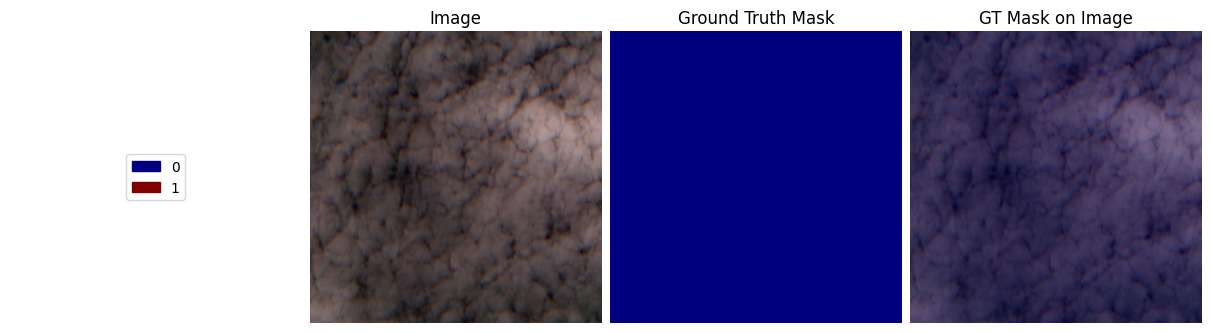

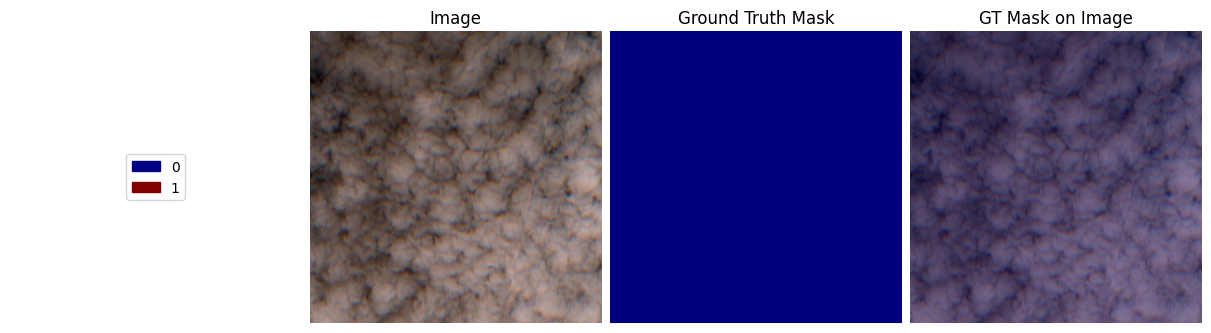

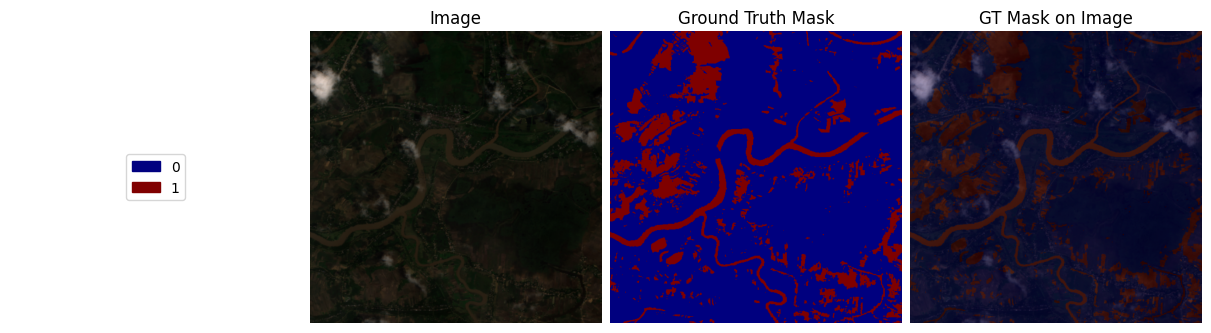

In [9]:
# Plotting a few samples (only "rgb_modality")
val_dataset.plot(val_dataset[0])
plt.show()
val_dataset.plot(val_dataset[9])
plt.show()
val_dataset.plot(val_dataset[11])
plt.show()

In [10]:
# Checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

90

# TerraTorch model registry

TerraTorch includes its own backbone registry with many EO FMs.

In [11]:
from terratorch.registry import BACKBONE_REGISTRY, TERRATORCH_BACKBONE_REGISTRY, TERRATORCH_DECODER_REGISTRY

In [12]:
# Print all TerraMind v1 backbones.
[backbone
 for backbone in TERRATORCH_BACKBONE_REGISTRY
 if 'terramind_v1' in backbone]
# TiM = Thinking-in-Modalities approach

['terramind_v1_base',
 'terramind_v1_base_tim',
 'terramind_v1_large',
 'terramind_v1_large_tim']

In [13]:
# Available decoders. UNetDecoder selected in experiment.
list(TERRATORCH_DECODER_REGISTRY)

['FCNDecoder',
 'IdentityDecoder',
 'SatMAEHead',
 'UperNetDecoder',
 'ASPPModule',
 'ASPPHead',
 'ASPPSegmentationHead',
 'ASPPRegressionHead',
 'MLPDecoder',
 'UNetDecoder',
 'LinearDecoder']

In [14]:
# Backbone registry to load a PyTorch model for custom pipeline.
# Pretrained=True, weights were downloaded automatically.
model = BACKBONE_REGISTRY.build(
    "terramind_v1_base_tim",
    modalities=["S2L1C", "S1GRD"],
    pretrained=True,
)

TerraMind_v1_base.pt:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [15]:
model

TerraMindTiM(
  (encoder_embeddings): ModuleDict(
    (untok_sen2l1c@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=3328, out_features=768, bias=False)
    )
    (untok_sen1grd@224): ImageEncoderEmbedding(
      (proj): Linear(in_features=512, out_features=768, bias=False)
    )
    (tok_lulc@224): ImageTokenEncoderEmbedding(
      (token_emb): Embedding(4375, 768)
    )
  )
  (sampler): GenerationSampler(
    (model): TerraMind(
      (encoder_embeddings): ModuleDict(
        (untok_sen2l1c@224): ImageEncoderEmbedding(
          (proj): Linear(in_features=3328, out_features=768, bias=False)
        )
        (untok_sen1grd@224): ImageEncoderEmbedding(
          (proj): Linear(in_features=512, out_features=768, bias=False)
        )
        (tok_lulc@224): ImageTokenEncoderEmbedding(
          (token_emb): Embedding(4375, 768)
        )
      )
      (decoder_embeddings): ModuleDict(
        (tok_lulc@224): ImageTokenDecoderEmbedding(
          (token_emb): Embedding(437

# Fine-tune TerraMind via PyTorch Lightning

- A fixed random seed ensures that the same results will be obtained every time.
- The model with the best validation mIoU score is saved as a custom checkpoint.
- The Lightning Trainer is set up for mixed precision, single-GPU training, and progress logging.
- Finally, a semantic segmentation model (SemanticSegmentationTask) is defined with a TerraMind backbone, UNet decoder, and dice loss. This includes settings for optimizer, learning rate, freezing, and validation plotting.

In [16]:
pl.seed_everything(0)

# Custom ModelCheckpoint, saving model with best validation mIoU score.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="/content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-mIoU",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # single-gpu
    precision="16-mixed",  # Speed up training with half precision
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=10, # Adjusting epochs, for experiment 10 vs. 50
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="/content/drive/MyDrive/output/terramind_base_tim_sen1floods11/",
)

# Segmentation mask that build the model and handles training and validation steps.
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",  # Combines a backbone with necks, the decoder, and a head
    model_args={
        # TerraMind backbone
        "backbone": "terramind_v1_base_tim",
        "backbone_pretrained": True,
        "backbone_modalities": ["S2L1C", "S1GRD"],

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                "indices": [2, 5, 8, 11] # indices for terramind_v1_base
            },
            {"name": "ReshapeTokensToImage",
             "remove_cls_token": False},
            {"name": "LearnedInterpolateToPyramidal"}  # Some decoders, like UNet or UperNet, need hierarchical features. Therefore, it is necessary to learn a upsampling technique for the intermediate embedding layers when using a ViT like TerraMind.
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 2,
    },

    loss="dice",  # Dice for binary tasks
    optimizer="AdamW",
    lr=1e-5,  # Learning rate inside recommended range by TerraTorch
    ignore_index=-1,
    freeze_backbone=True, # Speed up fine-tuning when backbone set to True. Recommended to fine-tune backbone, due to computational limitation not possible in this experiment
    freeze_decoder=False,
    plot_on_val=True,  # Plot predictions during validation steps
    class_names=["Others", "Water"]  # Class names
)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Start Tensorboard for interactive visualization tool during fine-tuning:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/output

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [17]:
# Testing of the fine-tuned model
best_ckpt_path = "/content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/best-mIoU-TIM-50.ckpt"
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)


INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/best-mIoU-TIM-50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/best-mIoU-TIM-50.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/best-mIoU-TIM-50.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/output/terramind_base_tim_sen1floods11/checkpoints/best-mIoU-TIM-50.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.9654181003570557          │
│      test/Multiclass_F1_Score       │         0.9654181599617004          │
│    test/Multiclass_Jaccard_Index    │         0.8638420104980469          │
│ test/Multiclass_Jaccard_Index_Micro │         0.9331480860710144          │
│              test/loss              │         0.24544034898281097         │
│   test/multiclassaccuracy_Others    │         0.9735299944877625          │
│    test/multiclassaccuracy_Water    │         0.9086712002754211          │
│ test/multiclassjaccardindex_Others  │         0.9609841108322144          │
│  test/multiclassjaccardindex_Water  │         0.7666998505592346          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 0.24544034898281097,
  'test/Multiclass_Accuracy': 0.9654181003570557,
  'test/multiclassaccuracy_Others': 0.9735299944877625,
  'test/multiclassaccuracy_Water': 0.9086712002754211,
  'test/Multiclass_F1_Score': 0.9654181599617004,
  'test/Multiclass_Jaccard_Index': 0.8638420104980469,
  'test/multiclassjaccardindex_Others': 0.9609841108322144,
  'test/multiclassjaccardindex_Water': 0.7666998505592346,
  'test/Multiclass_Jaccard_Index_Micro': 0.9331480860710144}]

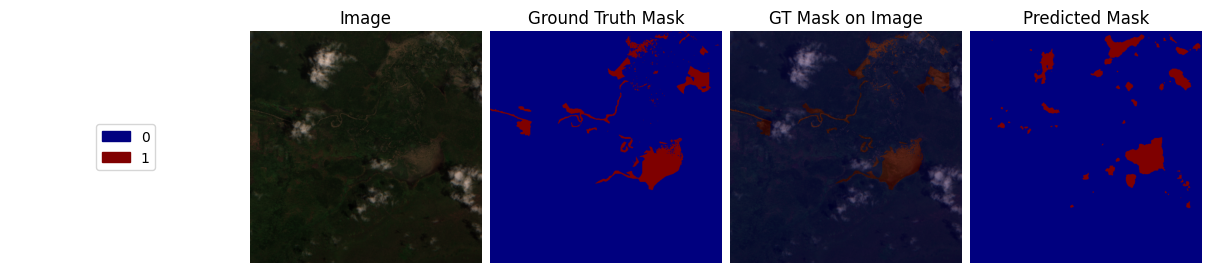

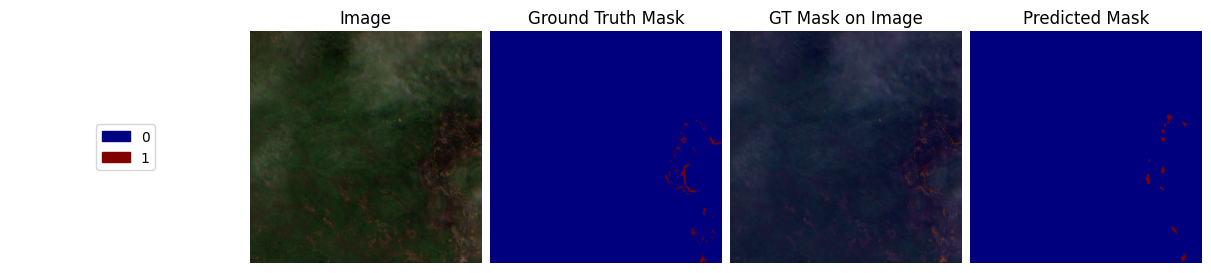

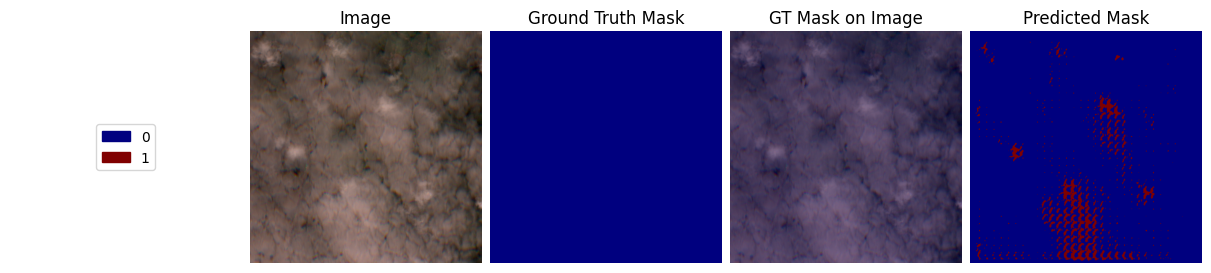

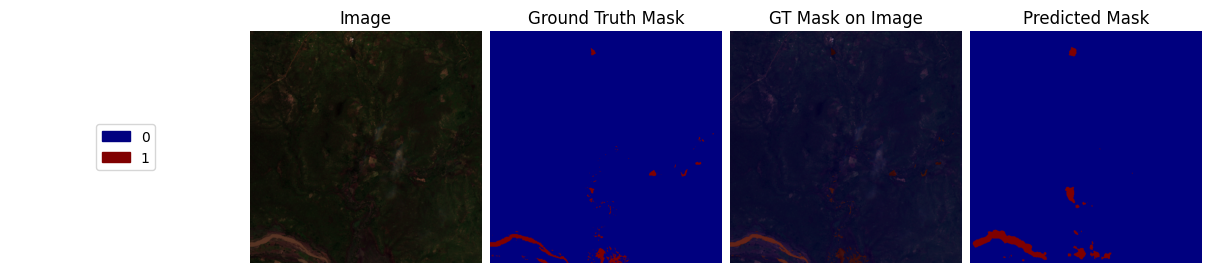

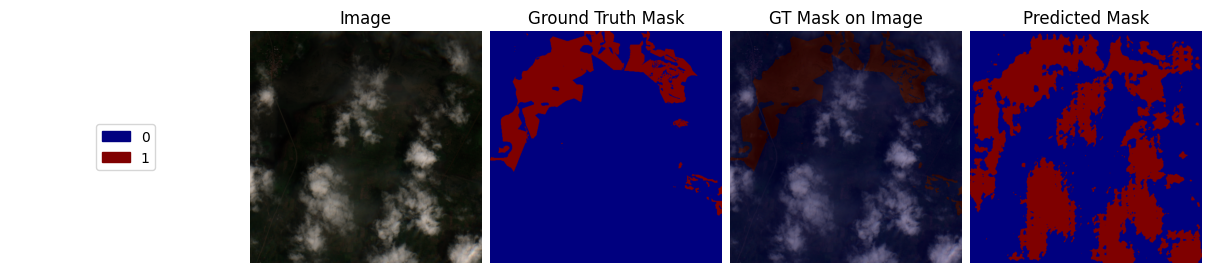

In [19]:
# Use the model for predictions and plotting
model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
)

test_loader = datamodule.test_dataloader()
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"]
    for mod, value in images.items():
        images[mod] = value.to(model.device)
    masks = batch["mask"].numpy()

    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {
        "image": batch["image"]["S2L1C"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    test_dataset.plot(sample)
    plt.show()
